## Download Dataset

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/vbookshelf/synthetic-cell-images-and-masks-bbbc005-v1/download?datasetVersionNumber=1")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alirezabarghgir
Your Kaggle Key: ··········


100%|██████████| 3.55G/3.55G [00:28<00:00, 134MB/s]


https://bbbc.broadinstitute.org/BBBC005/

**my repository:**
https://github.com/Barghgir/Synthetic-Cell


1.   List item
2.   List item



## Import necessary libraries

In [ ]:
from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from skimage.io import imread, imshow
from skimage.transform import resize

## Create DataFrame for dataset

In [ ]:
mask_lst_1 = glob("/content/synthetic-cell-images-and-masks-bbbc005-v1/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/*.TIF")
# mask_lst_2 = glob("/content/synthetic-cell-images-and-masks-bbbc005-v1/BBBC005_v1_ground_truth/synthetic_2_ground_truth/*.TIF")
# mask_lst = glob("/content/synthetic-cell-images-and-masks-bbbc005-v1/BBBC005_v1_ground_truth/*/*.TIF")


# len(glob("/content/synthetic-cell-images-and-masks-bbbc005-v1/BBBC005_v1_images/BBBC005_v1_ground_truth/*.TIF"))
img_lst = glob("/content/synthetic-cell-images-and-masks-bbbc005-v1/BBBC005_v1_images/BBBC005_v1_images/*.TIF")

In [ ]:
path = img_lst[1].replace(img_lst[1].split("/")[-1], "")

img_labeled = []
for i in mask_lst_1:
    new_path = path + i.split("/")[-1]
    if new_path in img_lst:
        img_labeled.append(new_path)

img_labeled.sort()
mask_lst_1.sort()

In [ ]:
dict_labeled = {
    "image_labeled": img_labeled,
    "mask_labeled": mask_lst_1,
}

df_labeled = pd.DataFrame(dict_labeled)

In [ ]:
# Add a column showing how many cells are on each image

def get_num_cells(x):
    x = x.split("/")[-1]
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[2] # e.g. C53
    # choose second item onwards and convert to int
    num_cells = int(b[1:])
    
    return num_cells

# create a new column called 'num_cells'
df_labeled['num_cells'] = df_labeled['image_labeled'].apply(get_num_cells)


# Add a column indicating if an image has a mask.

# Keep in mind images and masks have the same file names.

def check_for_mask(x):
    x = x.split("/")[-1]
    mask_list = [i.split("/")[-1] for i in mask_lst_1]
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'df_labeled'
df_labeled['has_mask'] = df_labeled['image_labeled'].apply(check_for_mask)


# Add a column showing how much blur was added to each image

def get_blur_amt(x):
    x = x.split("/")[-1]
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[3] # e.g. F1
    # choose second item onwards and convert to int
    blur_amt = int(b[1:])
    
    return blur_amt

# create a new column called 'blur_amt'
df_labeled['blur_amt'] = df_labeled['image_labeled'].apply(get_blur_amt)

In [ ]:
df_labeled.head()

,image_labeled,mask_labeled,num_cells,has_mask,blur_amt
0,/content/synthetic-cell-images-and-masks-bbbc0...,/content/synthetic-cell-images-and-masks-bbbc0...,1,yes,1
1,/content/synthetic-cell-images-and-masks-bbbc0...,/content/synthetic-cell-images-and-masks-bbbc0...,1,yes,1
2,/content/synthetic-cell-images-and-masks-bbbc0...,/content/synthetic-cell-images-and-masks-bbbc0...,1,yes,1
3,/content/synthetic-cell-images-and-masks-bbbc0...,/content/synthetic-cell-images-and-masks-bbbc0...,1,yes,1
4,/content/synthetic-cell-images-and-masks-bbbc0...,/content/synthetic-cell-images-and-masks-bbbc0...,1,yes,1


## Build Generator

In [ ]:
train_mount = int(df_labeled.shape[0] * 0.8)
val_mount = train_mount + int(df_labeled.shape[0] * 0.2)
# test_mount = val_mount + int(data_paths.shape[0] * 0.1)

print("Mount of training", train_mount)

Mount of training 960


In [ ]:
################################################################################
# Data Generator

# Defining generator functions for train/test samples
def get_input(path):     
    # read the image using skimage
    image = imread(path)
    
    # resize the image
    image = resize(image, (500, 500), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)

    return image

def get_output(path):
    # read the image using skimage
    mask = imread(path)
    
    # resize the image
    mask = resize(mask, (308, 308), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    return mask


def gen_pairs_train():
    data_paths = df_labeled
    for i in range(train_mount):
        # Get a random image each time
        idx = np.random.randint(0,train_mount)
        
        yield (get_input(data_paths["image_labeled"][idx]), get_output(data_paths["mask_labeled"][idx]))


def gen_pairs_test():
    data_paths = df_labeled
    for i in range(train_mount, val_mount):
        # Get a random image each time
        idx = np.random.randint(train_mount, val_mount)

        # x = tf.convert_to_tensor(get_input(data_paths["mixed_img"][idx]), dtype=tf.float32)
        # y = tf.convert_to_tensor(get_output(data_paths["inf_mask_paths"][idx]), dtype=tf.float32)
        x = get_input(data_paths["image_labeled"][idx])
        y = get_output(data_paths["mask_labeled"][idx])
        yield x, y

# Function to test input pipeline
sample_image, sample_label = next(gen_pairs_train())

In [ ]:
print(sample_image.shape)
print(sample_label.shape)

(500, 500, 1)
(308, 308, 1)


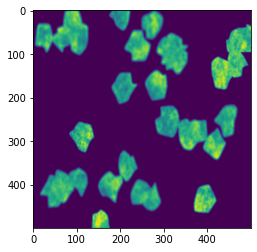

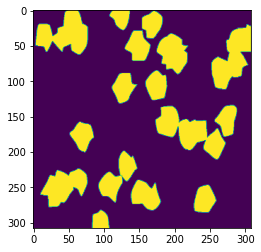

In [ ]:
# img = Image.open(df_labeled["image_labeled"][1000])
# np_img = np.array(img)

plt.imshow(sample_image[:,:,0])
plt.show()

# img = Image.open(df_labeled["mask_labeled"][1000])
# np_img = np.array(img)
# print(np_img.shape)

plt.imshow(sample_label[:,:,0])
plt.show()


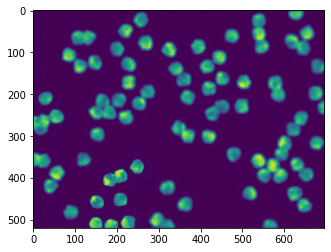

(520, 696)


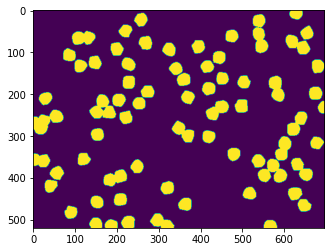

(520, 696)


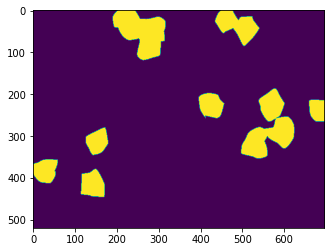

In [ ]:
img = Image.open(df_labeled["image_labeled"][1000])
np_img = np.array(img)

plt.imshow(np_img)
plt.show()

img = Image.open(df_labeled["mask_labeled"][1000])
np_img = np.array(img)
print(np_img.shape)

plt.imshow(np_img)
plt.show()

img = Image.open(df_labeled["mask_labeled"][len(df_labeled)-1001])
np_img = np.array(img)
print(np_img.shape)

plt.imshow(np_img)
plt.show()

## model

In [ ]:
from keras.layers import Layer
import tensorflow as tf
import keras.layers as Layers
from keras.layers import Conv2D, Input, BatchNormalization, ReLU, MaxPooling2D
from keras import Model
from keras.layers import Concatenate, GlobalAveragePooling2D, Conv2DTranspose, Resizing
from keras.layers import Flatten, Dense

class Downward_block(Layer):
    def __init__(self, num_filters):
        super(Downward_block, self).__init__()
        self.conv3_1 = Conv2D(num_filters, (3, 3), padding='valid', activation='relu')
        self.conv3_2 = Conv2D(num_filters, (3, 3), padding='valid', activation='relu')
        self.maxpool = MaxPooling2D((2, 2))

    def call(self, x):
        x = self.conv3_1(x)
        x_before_pool = self.conv3_2(x)
        x = self.maxpool(x_before_pool)
        return x, x_before_pool

In [ ]:
class Upward_block(Layer):
    def __init__(self, conv3_filters, upconv_filters):
        super(Upward_block, self).__init__()
        self.resize = Resizing
        self.conv3_1 = Conv2D(conv3_filters, (3, 3), padding='valid', activation='relu')
        self.conv3_2 = Conv2D(conv3_filters, (3, 3), padding='valid', activation='relu')
        self.concat = Concatenate(axis=3)
        self.upconv = Conv2DTranspose(filters=upconv_filters, kernel_size=(2, 2),
                                      strides=(2, 2), padding='valid', activation='relu')

    def call(self, x, y):
        
        x1 = self.upconv(x)
        # print("Shape of y (before concat)--->", y.shape)
        # print("Shape of x1 (before concat, after upconv)--->", x1.shape)
        # y = tf.image.resize(images=y, size=x.shape)
        y = self.resize(height=x1.shape[1], width=x1.shape[1])(y)
        # print("Shape of y (AFter resize)--->", y.shape)
        x2 = self.concat([y, x1])
        # print("Shape of x2 (after concat)--->", x2.shape)
        x2 = self.conv3_1(x2)
        # print("Shape of x2 (after conv3_1)--->", x2.shape)
        x2 = self.conv3_2(x2)
        # print("Shape of x2 (after conv3_2)--->", x2.shape)
        
        return x2


In [ ]:

class Unet(Model):
    def __init__(self):
        super(Unet, self).__init__()
        
        self.down1 = Downward_block(64)
        self.down2 = Downward_block(128)
        self.down3 = Downward_block(256)
        self.down4 = Downward_block(512)
                    
        self.conv3_1 = Conv2D(1024, (3, 3), padding='valid', activation='relu')
        self.conv3_2 = Conv2D(1024, (3, 3), padding='valid', activation='relu')

        self.up4 = Upward_block(512, 512)
        self.up3 = Upward_block(256, 256) 
        self.up2 = Upward_block(128, 128) 
        self.up1 = Upward_block(64, 64) 

        self.conv1 = Conv2D(1, (1, 1), padding='same', activation='relu')
        

    def call(self, x):
        x, x1 = self.down1(x)
        # print("Shape of x1 --->", x1.shape)
        # print("Shape of x --->", x.shape)
        x, x2 = self.down2(x)
        # print("Shape of x2 --->", x2.shape)
        # print("Shape of x --->", x.shape)
        x, x3 = self.down3(x)
        # print("Shape of x3 --->", x3.shape)
        # print("Shape of x --->", x.shape)
        x, x4 = self.down4(x)
        # print("Shape of x4 --->", x4.shape)
        # print("Shape of x --->", x.shape)
        x = self.conv3_1(x)
        # print("Shape of x --->", x.shape)
        x = self.conv3_2(x)
        # print("Shape of x --->", x.shape)
        x = self.up4(x, x4)
        # print("Shape of x (after up4)--->", x.shape)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)

        x = self.conv1(x)

        return x




    # def build(self, input_shape):
    #     x = self.input_layer()
    #     output = self.call(x)
    #     return Model(inputs=x, outputs=output)

    
    def summary_model(self):
        inputs = Input(shape=(500, 500, 1))
        outputs = self.call(inputs)
        Model(inputs=inputs, outputs=outputs).summary()


In [ ]:
model = Unet()

https://iq.opengenus.org/output-size-of-convolution/

In [ ]:
# model.build((None, 572, 572, 1))
model.summary_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 1  0           []                               
                                )]                                                                
                                                                                                  
 downward_block (Downward_block  ((None, 248, 248, 6  37568      ['input_1[0][0]']                
 )                              4),                                                               
                                 (None, 496, 496, 6                                               
                                4))                                                               
                                                                                              

## Train model

### Use Data Generators

In [ ]:
batch_size = 8
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_train, output_types=(np.float32, np.float32))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_test, output_types=(np.float32, np.float32))
test_dataset = test_dataset.batch(batch_size)

### Loss function

In [ ]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

dice_loss = DiceLoss()
# dice_loss = tf.losses.CategoricalCrossentropy()

### Training loop

In [ ]:
epochs = 10
learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate)

def train_one_batch(x, y):
    y = tf.reshape(y, shape=(batch_size, 308, 308, 1))
    
    with tf.GradientTape() as tape:
        pred = model(x, training=True)
        loss = dice_loss(y, pred)

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))


def validate_one_batch(x, y):
    y = tf.reshape(y, shape=(batch_size, 308, 308, 1))
    pred = model(x, training=False)
    loss = dice_loss(y, pred)
    return loss

In [ ]:


for epoch in range(epochs):
    for batch, (input, target) in enumerate(train_dataset):
        train_one_batch(input, target)
    print(f"\r EPOCH [{epoch+1}/{epochs}] Batch: {batch}")


    val_loss = []
    for input_test, target_test in test_dataset:
        loss = validate_one_batch(input_test, target_test)
        val_loss.append(loss)

    print("Validation Loss :   ", str(np.mean(val_loss)))

 EPOCH [1/10] Batch: 119
Validation Loss :    0.03097314
 EPOCH [2/10] Batch: 119
Validation Loss :    0.02527629
 EPOCH [3/10] Batch: 119
Validation Loss :    0.023281546
 EPOCH [4/10] Batch: 119
Validation Loss :    0.020058563
 EPOCH [5/10] Batch: 119
Validation Loss :    0.015371394
 EPOCH [6/10] Batch: 119
Validation Loss :    0.015244957
 EPOCH [7/10] Batch: 119
Validation Loss :    0.012386522
 EPOCH [8/10] Batch: 119
Validation Loss :    0.011496584
 EPOCH [9/10] Batch: 119
Validation Loss :    0.012467344
 EPOCH [10/10] Batch: 119
Validation Loss :    0.011893189


## Made an example

In [ ]:
from random import randint
testing_x = get_input(df_labeled["image_labeled"][randint(0, len(df_labeled)+1)])
testing_x = np.expand_dims(testing_x, axis=0)
y_pred = model(testing_x)

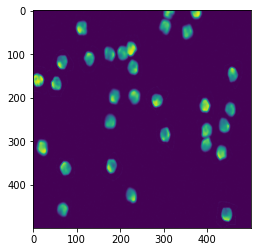

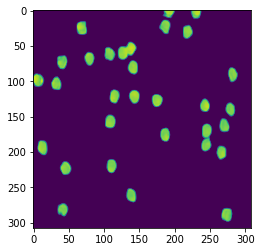

In [ ]:
plt.imshow(testing_x[0,:,:,0])
plt.show()

plt.imshow(y_pred[0,:,:,0])
plt.show()